In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

In [2]:
def plot_true_vs_predicted(ax, y_true, y_pred, title):
    """
    Plot true vs predicted values on the given Axes object.

    Parameters:
    - ax: Matplotlib Axes object to plot on.
    - y_true: True target values.
    - y_pred: Predicted values from the model.
    - title: Title for the plot.
    """
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_title(title)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    
def create_metrics_table_plotly(train_rmse, train_mae, train_r2, val_rmse, val_mae, val_r2, test_rmse, test_mae, test_r2, vrh_rmse, vrh_mae, vrh_r2):
    """
    Create an interactive table of error metrics using Plotly.

    Parameters:
    - train_rmse, train_mae, train_r2: Training RMSE, MAE, and R-squared metrics
    - val_rmse, val_mae, val_r2: Validation RMSE, MAE, and R-squared metrics
    - test_rmse, test_mae, test_r2: Test RMSE, MAE, and R-squared metrics
    - vrh_rmse, vrh_mae, vrh_r2: RMSE, MAE, and R-squared metrics on VRH values

    Returns:
    - A Plotly figure containing the metrics table.
    """
    # Header
    header_values = ["Metrics", "Training", "Validation", "Test", "VRH"]
    # Cells
    cell_values = [
        ["RMSE", "MAE", "R-squared"],
        [f"{train_rmse:.2f}", f"{train_mae:.2f}", f"{train_r2:.4f}"],
        [f"{val_rmse:.2f}", f"{val_mae:.2f}", f"{val_r2:.4f}"],
        [f"{test_rmse:.2f}", f"{test_mae:.2f}", f"{test_r2:.4f}"],
        [f"{vrh_rmse:.2f}", f"{vrh_mae:.2f}", f"{vrh_r2:.4f}"]
    ]
    
    # Initialize a figure with go.Table
    fig = go.Figure(data=[go.Table(
        header=dict(values=header_values,
                    fill_color='paleturquoise',
                    align='center',
                    font=dict(color='black', size=12)),
        cells=dict(values=cell_values,
                   fill_color='lavender',
                   align='center'))
    ])
    return fig


def plot_results(xlabel, df, predictions, sonic, v_label, r_label, vrh_label, xlim_lr, xlim_upr, ylim_lr = False, ylim_upr = False, bckg = False):
    """
    Plots various geological log data and machine learning predictions as a function of depth.
    
    Parameters:
    - xlabel (str): Label for the x-axis.
    - df (DataFrame): Pandas DataFrame containing the well log data.
    - predictions (array-like): Predicted values from a machine learning model.
    - sonic (array-like): Sonic log values from the DataFrame.
    - v_label (str): Column name in df for Voigt boundary data.
    - r_label (str): Column name in df for Reuss boundary data.
    - vrh_label (str): Column name in df for Voigt-Reuss-Hill average data.
    - xlim_lr (float): Lower limit for the x-axis range.
    - xlim_upr (float): Upper limit for the x-axis range.
    - ylim_lr (float, optional): Lower limit for the y-axis range. Defaults to False, which auto-scales.
    - ylim_upr (float, optional): Upper limit for the y-axis range. Defaults to False, which auto-scales.
    - bckg (str or False, optional): Background color for the area between Voigt and Reuss boundaries. If False, yellow is used as the default color.
    
    The function creates a vertical plot typically used for well log representation with depth increasing downwards. 
    It plots the sonic log, machine learning predictions, and the Voigt-Reuss-Hill average as lines on the same plot. 
    It also shades the area between the Voigt and Reuss boundaries to indicate uncertainty or variability range. 
    The function allows for customization of the x and y-axis limits and the background color for the shaded area.
    """

    depth = df['DEPT']
    voigt_boundary = df[v_label]
    reuss_boundary = df[r_label]
    vp_vrh = df[vrh_label]
    xlen = df.shape[0]
    
    plt.figure(figsize=(9, 10))
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    
    for _, el in formation_depths.iterrows():
        plt.axhline(y=el['Min Value'], color='grey', linestyle='--', linewidth=1, alpha=0.3)
        plt.axhline(y=el['Max Value'], color='grey', linestyle='--', linewidth=1, alpha=0.3)
#         if np.isfinite(el['Min Value']) and np.isfinite(el['Max Value']):
#               plt.fill_betweenx(y=[el['Min Value'], el['Max Value']], 
#                                 x1=xlim_lr, x2=xlim_upr,
#                                 color=el['color'], alpha=0.1)
                
    plt.plot(sonic, depth, label='Sonic Log', alpha=1)
    plt.plot(predictions, depth, label='ML Predictions', alpha=0.8, color='red')
    plt.plot(vp_vrh, depth, label='Voigt Reuss Hill', alpha=0.5, color='black')
    plt.plot(voigt_boundary, depth,  alpha=0.8, linewidth=0.4, color='violet')
    plt.plot(reuss_boundary, depth, label='Voigt-Reuss Boundaries', alpha=0.8, linewidth=0.4, color='violet')
    
    if bckg:
        plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                      interpolate=True, color=bckg, alpha=0.5)
    else:
        plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                      interpolate=True, color='yellow', alpha=0.5)
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2, 
               framealpha=1.0, edgecolor='black', facecolor='white', frameon=True)
    
    plt.ylabel('Depth [m]', fontweight='bold', labelpad=15)
    plt.xlabel(xlabel, fontweight='bold', labelpad=15)
    
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'arial'
    
    plt.xlim(xlim_lr, xlim_upr)
    if (ylim_lr and ylim_upr):
        plt.ylim(ylim_lr, ylim_upr)

    plt.show()
    
def plot_true_vs_predicted_v1(ax, true_data, predicted_data, label, marker, color):
    ax.scatter(true_data, predicted_data, alpha=0.7, label=label, marker=marker, color=color)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.legend()
    
def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))
    
def plot_true_vs_vrh(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.4, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('VRH Values', fontweight='bold')
    ax.set_title('True vs VRH', fontweight='bold')
    plt.xlim(2000, 7000)
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))
    
def calculate_voigt_reuss_bounds(df, minerals, bulk_modulus, shear_modulus):
    dataset = df[minerals]
    voigt_bulk = []
    reuss_bulk = []
    voigt_shear = []
    reuss_shear = []
    
    for index, row in dataset.iterrows():
        sum_voigt_bulk = sum_voigt_shear = 0
        sum_reuss_bulk = sum_reuss_shear = 0
        for mineral in minerals:
            volume_fraction = row[mineral]
            sum_voigt_bulk += volume_fraction * bulk_modulus[mineral]
            sum_voigt_shear += volume_fraction * shear_modulus[mineral]
            # Avoiding /0
            if bulk_modulus[mineral] > 0:
                sum_reuss_bulk += volume_fraction / bulk_modulus[mineral]
            if shear_modulus[mineral] > 0:
                sum_reuss_shear += volume_fraction / shear_modulus[mineral]
        voigt_bulk.append(sum_voigt_bulk)
        voigt_shear.append(sum_voigt_shear)
        reuss_bulk_value = 1 / sum_reuss_bulk if sum_reuss_bulk > 0 else 0
        reuss_shear_value = 1 / sum_reuss_shear if sum_reuss_shear > 0 else 0
        reuss_bulk.append(reuss_bulk_value)
        reuss_shear.append(reuss_shear_value)
        
        df.loc[index, 'Voigt_Bulk'] = sum_voigt_bulk
        df.loc[index, 'Reuss_Bulk'] = reuss_bulk_value
        df.loc[index, 'Voigt_Shear'] = sum_voigt_shear
        df.loc[index, 'Reuss_Shear'] = reuss_shear_value
    df['K_VRH'] = (df['Voigt_Bulk']+df['Reuss_Bulk'])/2
    df['G_VRH'] = (df['Voigt_Shear']+df['Reuss_Shear'])/2
    
    return df

In [3]:
# Importing the Data
df = pd.read_csv("DATASETS/df.csv")

train_df_vp = pd.read_csv("DATASETS/train_df_vp.csv")
test_df_vp = pd.read_csv("DATASETS/test_df_vp.csv")
test_df2_vp = pd.read_csv("DATASETS/test_df2_vp.csv")

train_df_vs = pd.read_csv("DATASETS/train_df_vs.csv")
test_df_vs = pd.read_csv("DATASETS/test_df_vs.csv")
test_df2_vs = pd.read_csv("DATASETS/test_df2_vs.csv")

formations = pd.read_excel("Rock Formation Depths.xlsx")

In [4]:
# Manually Generating a Dataframe with required rock formation Depths

layers = {
    "Layer": [
        "Eau Claire A-C", "Mt. Simon E", "Mt. Simon D", "Mt. Simon C",
        "Mt. Simon B", "Mt. Simon A", "Argenta", "Precambrian rhyolite"
    ],
    "Min Value": [5380, 5552, 5907, 6117, 6428, 6668, 7043, 7162],
    "Max Value": [5552, 5907, 6117, 6428, 6668, 7043, 7162, 8000],
    "color": ['grey','purple','purple','purple','purple','purple','red','blue']
}
formation_depths = pd.DataFrame(layers)

In [5]:
formation_depths.head(10)

Layer  Min Value  Max Value   color
0        Eau Claire A-C       5380       5552    grey
1           Mt. Simon E       5552       5907  purple
2           Mt. Simon D       5907       6117  purple
3           Mt. Simon C       6117       6428  purple
4           Mt. Simon B       6428       6668  purple
5           Mt. Simon A       6668       7043  purple
6               Argenta       7043       7162     red
7  Precambrian rhyolite       7162       8000    blue

In [6]:
def feet_to_meters(feet):
    return feet * 0.3048

test_df_vs['DEPT'] = test_df_vs['DEPT'].apply(feet_to_meters)
test_df_vp['DEPT'] = test_df_vp['DEPT'].apply(feet_to_meters)

test_df2_vs['DEPT'] = test_df2_vs['DEPT'].apply(feet_to_meters)
test_df2_vp['DEPT'] = test_df2_vp['DEPT'].apply(feet_to_meters)

In [7]:
formation_depths['Min Value'] = formation_depths['Min Value'].apply(feet_to_meters)
formation_depths['Max Value'] = formation_depths['Max Value'].apply(feet_to_meters)

In [8]:
formation_depths.head(10)

Layer  Min Value  Max Value   color
0        Eau Claire A-C  1639.8240  1692.2496    grey
1           Mt. Simon E  1692.2496  1800.4536  purple
2           Mt. Simon D  1800.4536  1864.4616  purple
3           Mt. Simon C  1864.4616  1959.2544  purple
4           Mt. Simon B  1959.2544  2032.4064  purple
5           Mt. Simon A  2032.4064  2146.7064  purple
6               Argenta  2146.7064  2182.9776     red
7  Precambrian rhyolite  2182.9776  2438.4000    blue

# Random Forest

## TRAINING FOR VP

In [9]:
target_column = 'VP'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vp[predictor_cols]
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [10]:
filename = 'best_rf_model.joblib'
best_rf = joblib.load(filename)

In [11]:
# Evaluate the best model on the validation set
val_predictions = best_rf.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

print('Validation MAE: ', val_mae)
print('Validation R-squared: ', val_r2)

Validation MAE:  151.00055308018477
Validation R-squared:  0.9475660053231809


In [12]:
# TEST SET PREDICTIONS
X_test = test_df_vp.drop(['VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vp['VP']
X_test_scaled = scaler.transform(X_test)

y_test_pred_vp = best_rf.predict(X_test_scaled)
y_val_pred = best_rf.predict(X_val_scaled)
y_train_pred = best_rf.predict(X_train_scaled)

# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Calculate error metrics for the test set
test_rmse = mean_squared_error(y_test, y_test_pred_vp, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_vp)
test_r2 = r2_score(y_test, y_test_pred_vp)

# Calculate metrics for the VRH values
vrh_rmse = mean_squared_error(y_test, list(test_df_vp['VRH_VP']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vp['VRH_VP']))
vrh_r2 = r2_score(y_test, list(test_df_vp['VRH_VP']))

### 2. Plotting predictions with True Values

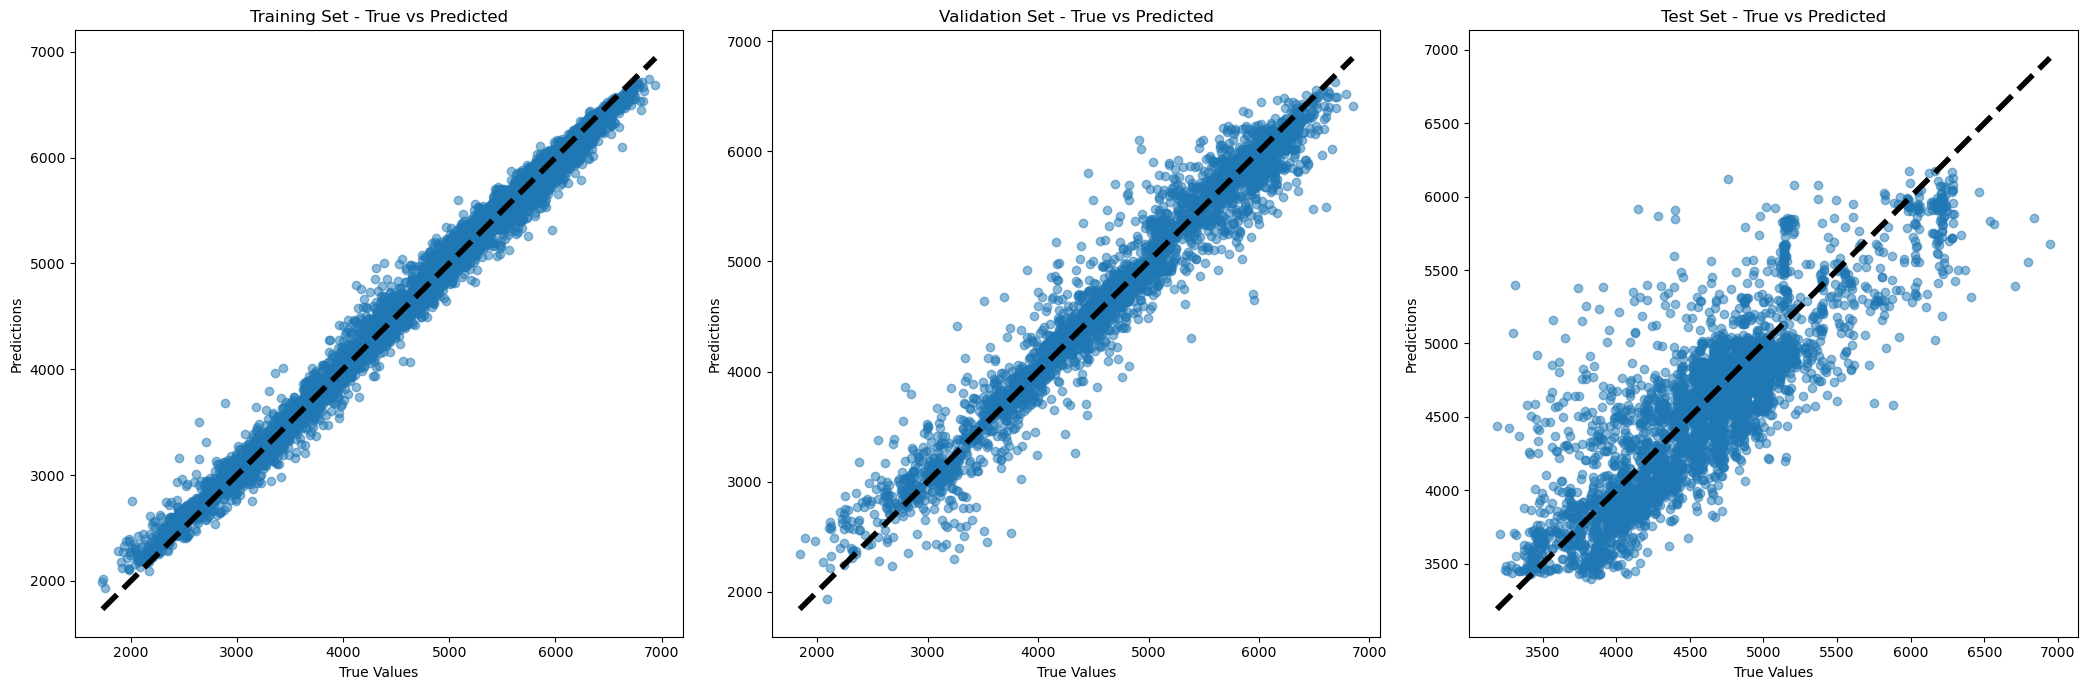

In [13]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, y_train_pred, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, y_val_pred, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, y_test_pred_vp, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

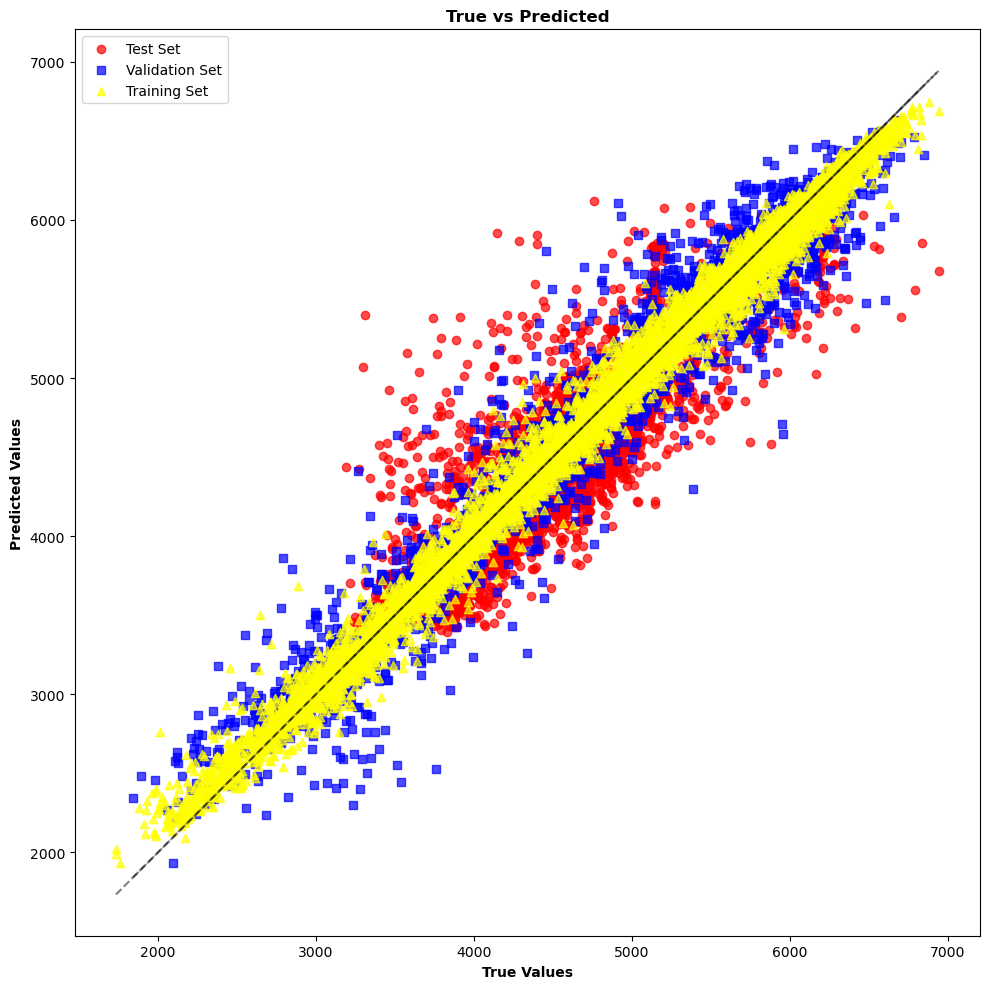

In [14]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v1(ax, y_test, y_test_pred_vp, 'Test Set', 'o', 'red')
plot_true_vs_predicted_v1(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue')
plot_true_vs_predicted_v1(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow')

plt.tight_layout()
plt.show()

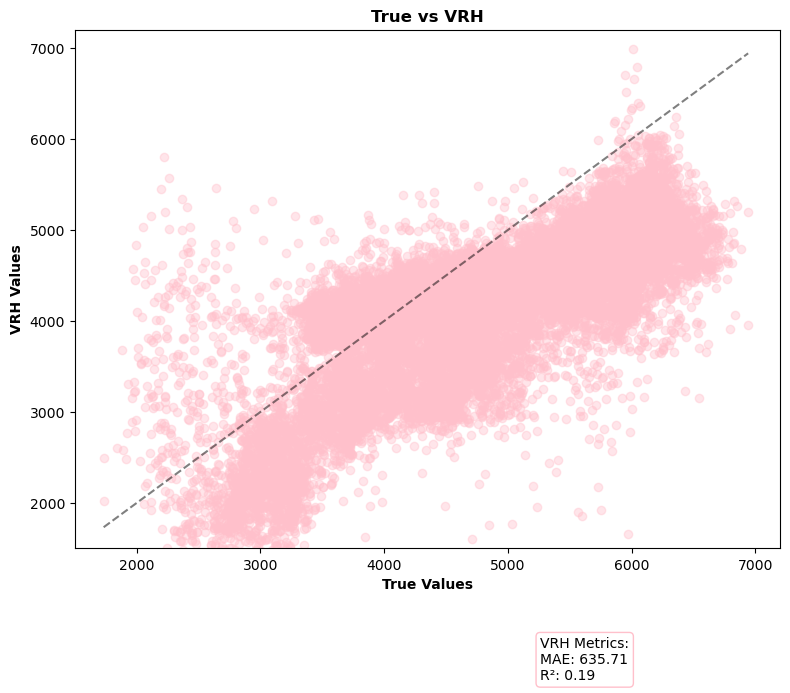

In [18]:
def plot_true_vs_vrh(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.4, label=f'{label}', color=color, marker=marker)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('VRH Values', fontweight='bold')
    ax.set_title('True vs VRH', fontweight='bold')
    plt.xlim(1500, 7200)
    plt.ylim(1500, 7200)
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

plot_true_vs_vrh(ax, df['VP'], df['VRH_VP'], 'VRH', 'o', 'pink', 0.66, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### 3. Comparing Metrics

In [19]:
fig = create_metrics_table_plotly(train_rmse, train_mae, train_r2, val_rmse, val_mae, val_r2, test_rmse, test_mae, test_r2, vrh_rmse, vrh_mae, vrh_r2)
fig.show()

### 4. Plotting Results

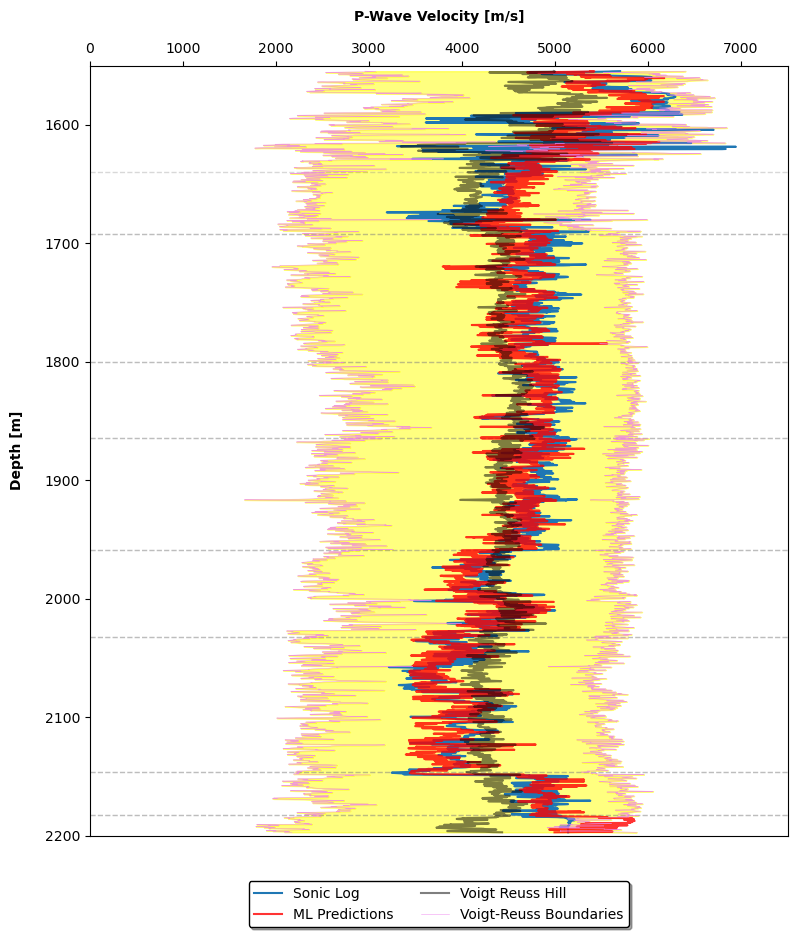

In [20]:
plot_results('P-Wave Velocity [m/s]', test_df_vp, y_test_pred_vp, y_test, 'VOIGT_VP', 'REUSS_VP','VRH_VP', 0, 7500, 2200, 1550)

## TRAINING FOR VS

In [21]:
target_column = 'VS'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vs[predictor_cols]
y = train_df_vs[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [22]:
filename = 'best1_xgb_model.joblib'
best_model = joblib.load(filename)

In [23]:
# TEST SET
X_test = test_df_vs.drop(['VS', 'RHOZ', 'VOIGT_VS', 'REUSS_VS', 'VRH_VS', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vs['VS']

X_test_scaled = scaler.transform(X_test)

In [24]:
y_val_pred = best_model.predict(X_val_scaled)
y_train_pred = best_model.predict(X_train_scaled)

In [25]:
y_test_pred_vs = best_model.predict(X_test_scaled)

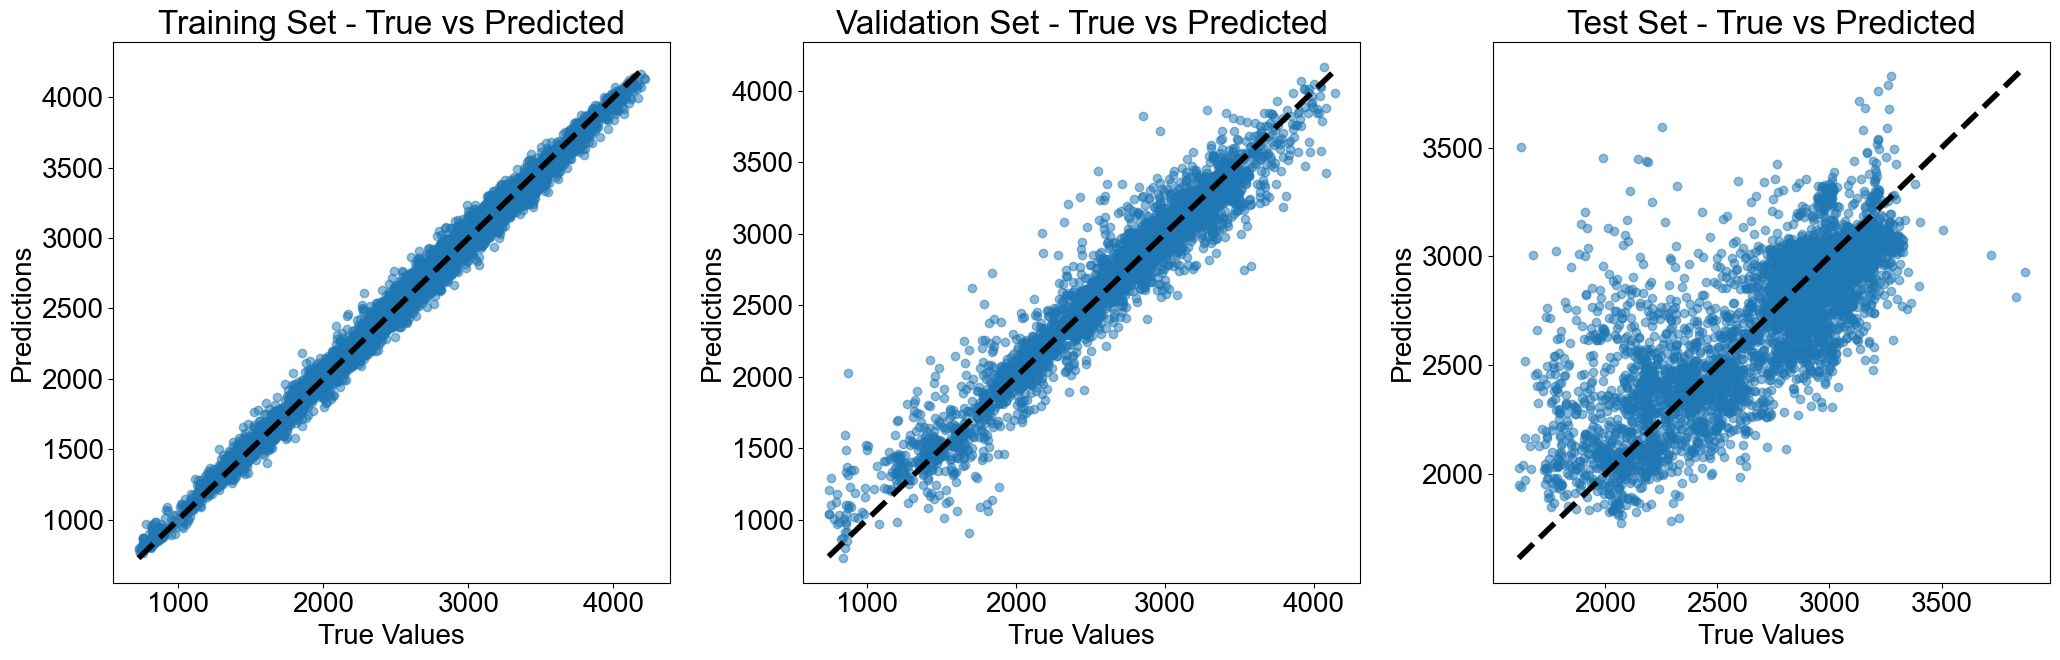

In [26]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, y_train_pred, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, y_val_pred, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, y_test_pred_vs, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

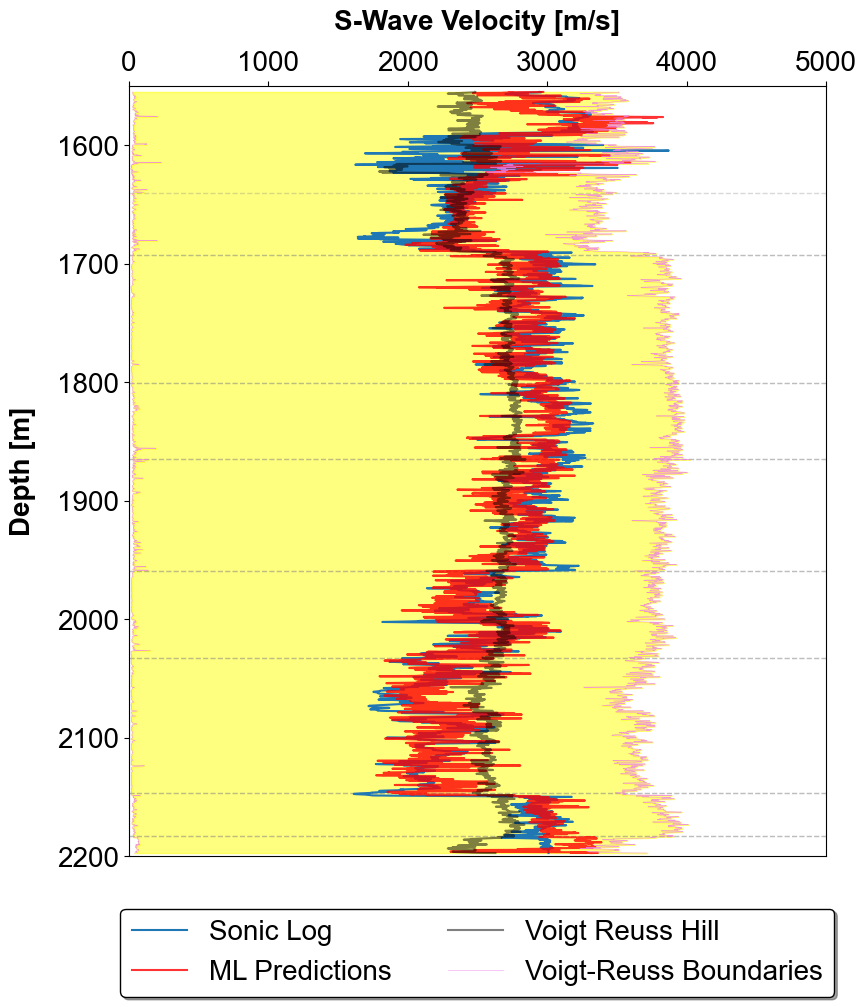

In [27]:
plot_results('S-Wave Velocity [m/s]', test_df_vs, y_test_pred_vs, y_test, 'VOIGT_VS', 'REUSS_VS','VRH_VS', 0, 5000, 2200, 1550)